In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [ ]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [3]:

sheet = pd.read_excel('data_input_auto/中国汽油社会库存.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
sheet.index.freq = None
last_day = sheet['中国汽油社会库存'].last_valid_index()
# 获取last_day之后的数据
future_data_30days = sheet[sheet.index > last_day]
# 计算需要的31个工作日
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=20, freq='B')
target_end = target_days[-1]


if len(future_data_30days) == 0:
    new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
    sheet = sheet.reindex(sheet.index.union(new_index))

elif future_data_30days.index.max() > target_end:
    sheet = sheet[sheet.index <= target_end]
    new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
    sheet = sheet.reindex(sheet.index.union(new_index))

else:
    max_future_date = future_data_30days.index.max() if len(future_data_30days) > 0 else last_day
    new_index = pd.date_range(start=max_future_date+ pd.DateOffset(1), end=target_end, freq='B')
    sheet = sheet.reindex(sheet.index.union(new_index))

sheet = sheet.sort_index()


In [4]:

fill_methods = { 
    '汽油情绪指数/4WMA': 'interpolate',  
    '中国汽油实际消费量Seasonal(预测/上一年季节性)/4WMA': 'interpolate',
    '山东汽油裂解差/30DMA': 'interpolate',
    'A股餐饮旅游指数60日环比/30DMA': 'interpolate'
} 
sheet_daily = fill_missing_values(sheet, fill_methods, return_only_filled=False)

sheet_daily['汽油情绪指数/4WMA_提前10天'] = sheet_daily['汽油情绪指数/4WMA'].shift(10)
sheet_daily['中国汽油实际消费量Seasonal(预测/上一年季节性)/4WMA_提前10天'] = sheet_daily['中国汽油实际消费量Seasonal(预测/上一年季节性)/4WMA'].shift(10)
sheet_daily['山东汽油裂解差/30DMA_提前30天'] = sheet_daily['山东汽油裂解差/30DMA'].shift(30)
sheet_daily['A股餐饮旅游指数60日环比/30DMA_提前30天'] = sheet_daily['A股餐饮旅游指数60日环比/30DMA'].shift(30)



sheet_daily.reset_index(inplace=True)
sheet_daily.rename(columns={'index': 'Date'}, inplace=True)

sheet_daily = sheet_daily[(sheet_daily['Date'] > last_day) | sheet_daily['中国汽油社会库存'].notna()]

sheet_daily = sheet_daily[sheet_daily['Date'] >= '2024-01-01']

In [5]:
sheet_daily.head()

,Date,中国汽油社会库存,汽油情绪指数/4WMA,中国汽油实际消费量Seasonal(预测/上一年季节性)/4WMA,山东汽油裂解差/30DMA,A股餐饮旅游指数60日环比/30DMA,汽油情绪指数/4WMA_提前10天,中国汽油实际消费量Seasonal(预测/上一年季节性)/4WMA_提前10天,山东汽油裂解差/30DMA_提前30天,A股餐饮旅游指数60日环比/30DMA_提前30天
5823,2024-01-05,502.22,20.75,-18.1903,636.4656,-0.1726,5.00,-26.17484,191.4350,-0.1936
5828,2024-01-12,504.24,38.25,-11.2983,692.8986,-0.1597,1.40,-31.28232,221.1705,-0.1870
5833,2024-01-19,504.94,31.00,-7.8452,703.0087,-0.1316,20.75,-18.19030,325.0873,-0.1810
5838,2024-01-26,515.06,35.50,0.4192,686.6635,-0.1093,38.25,-11.29830,448.3111,-0.1771
5843,2024-02-02,500.90,21.25,0.3084,700.4489,-0.0945,31.00,-7.84520,511.2558,-0.1773


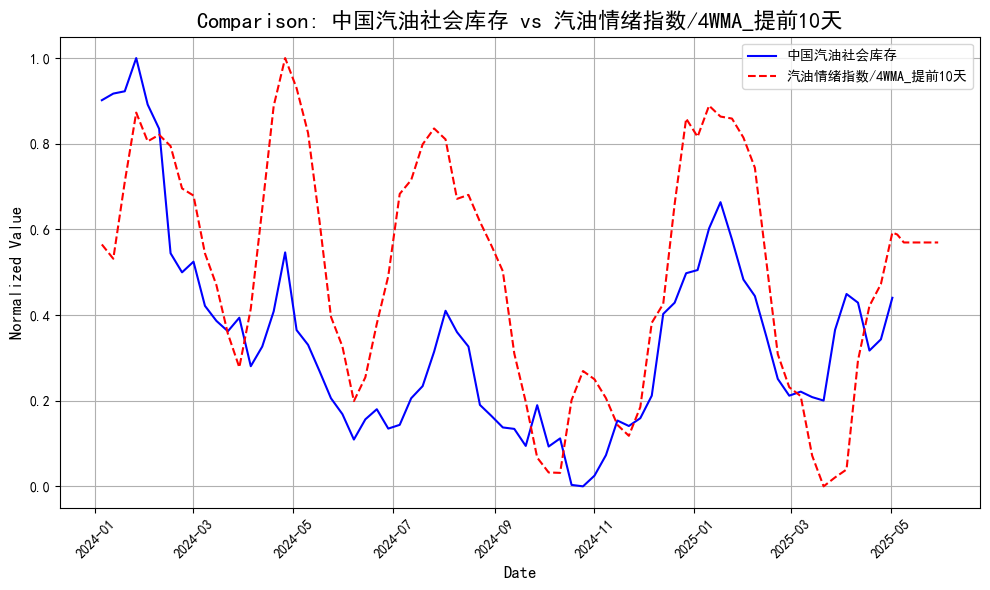

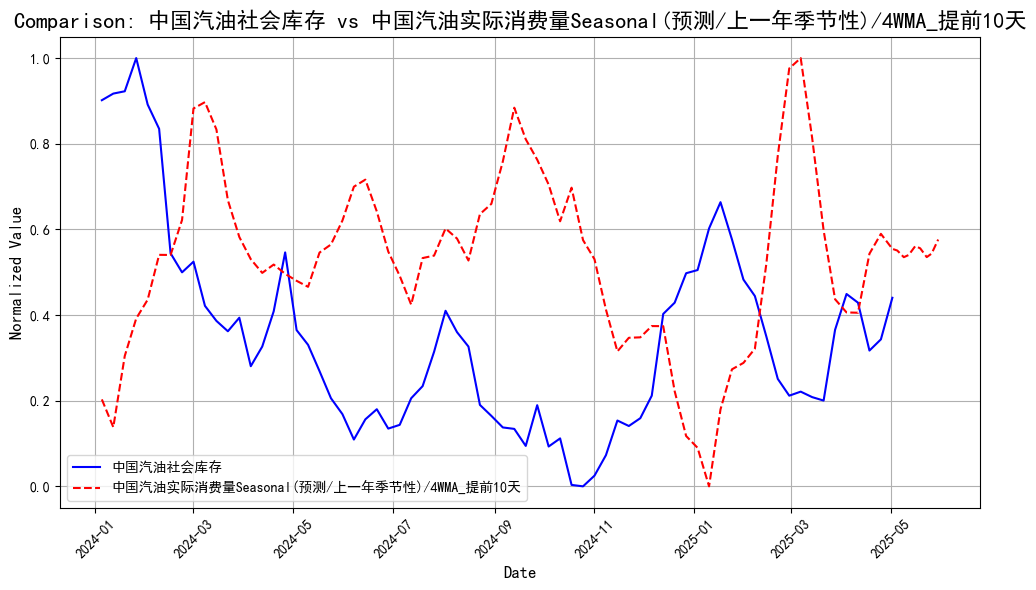

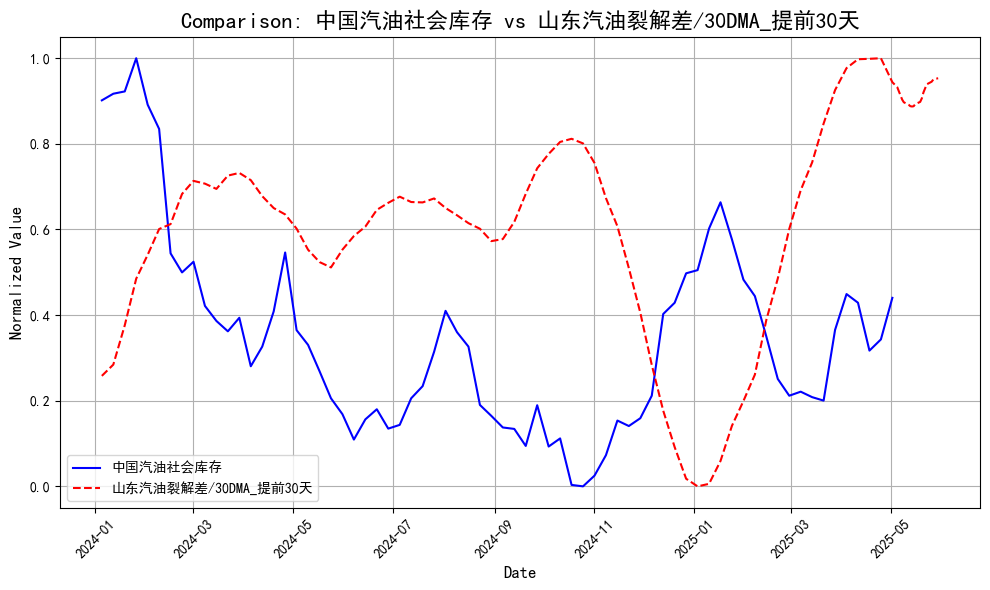

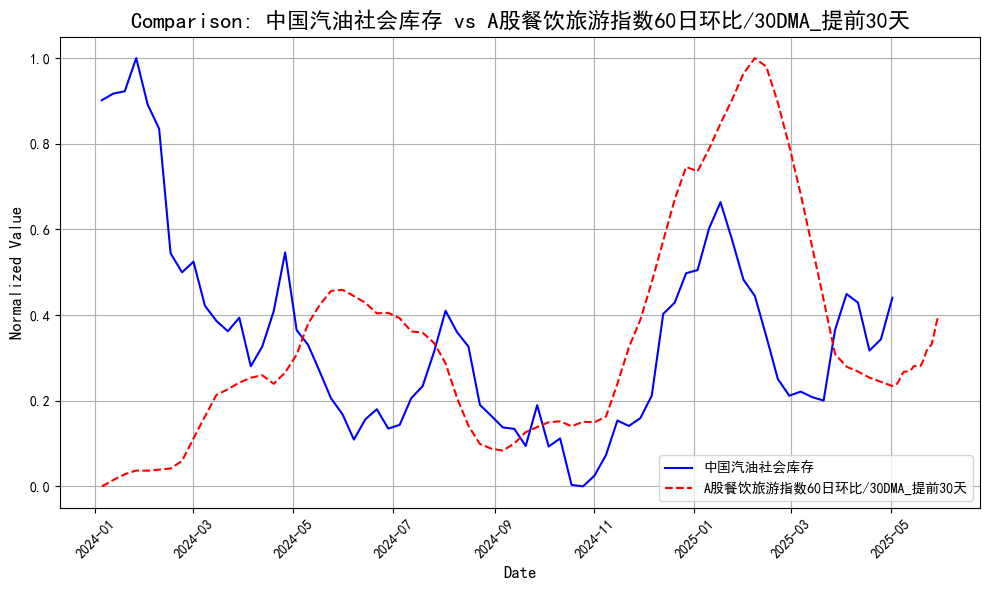

In [6]:
sheet_daily = sheet_daily[sheet_daily['Date'] >= '2024-01-01']
sheet_daily_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='中国汽油社会库存', 
    compare_cols=[
        '汽油情绪指数/4WMA_提前10天','中国汽油实际消费量Seasonal(预测/上一年季节性)/4WMA_提前10天',
        '山东汽油裂解差/30DMA_提前30天','A股餐饮旅游指数60日环比/30DMA_提前30天'
        ]
)

In [7]:
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 5
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

# 因子集
feature_columns = [
        '汽油情绪指数/4WMA_提前10天','中国汽油实际消费量Seasonal(预测/上一年季节性)/4WMA_提前10天',
        '山东汽油裂解差/30DMA_提前30天','A股餐饮旅游指数60日环比/30DMA_提前30天'
]
# 预测目标column
predict_column = '中国汽油社会库存'

# 准备训练、测试和未来数据的输入和输出
X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

In [8]:
# 初始化 MinMaxScaler
scaler = StandardScaler()

# 归一化特征数据
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

# 定义并训练 XGBRegressor 模型
xgb = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=800,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.9,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.5,
    early_stopping_rounds=20
)

# 训练模型，并设置 early_stopping_rounds
xgb.fit(
    X_train_scaled, 
    y_train,
    eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
)


# 自定义早停机制
best_score = float('inf')
early_stop_rounds = 20
no_improve_rounds = 0

for n in range(1, 101):  # 假设最多训练 100 轮
    xgb = XGBRegressor(
        objective='reg:squarederror',
        n_estimators=n,
        learning_rate=0.08,
        max_depth=3,
        subsample=0.9,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=0.5
    )
    xgb.fit(X_train_scaled, y_train)
    
    y_test_pred = xgb.predict(X_test_scaled)
    test_score = mean_squared_error(y_test, y_test_pred)
    
    if test_score < best_score:
        best_score = test_score
        no_improve_rounds = 0
    else:
        no_improve_rounds += 1

    if no_improve_rounds >= early_stop_rounds:
        print(f"Early stopping at round {n}")
        break

print(f"Best Test MSE: {best_score}")


# 训练集和测试集的预测
y_train_pred = xgb.predict(X_train_scaled)
y_test_pred = xgb.predict(X_test_scaled)

# 计算 MSE 和 R^2 分数
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train MSE: {train_mse}, Train R^2: {train_r2}")
print(f"Test MSE: {test_mse}, Test R^2: {test_r2}")

# 未来预测
'''
X_all = sheet_daily[sheet_daily['Date'] <= last_day][['汽油情绪指数/4WMA_提前30天', '汽油情绪指数/4WMA_提前30天', '中国10年期国债收益率_提前30天', '汽油：出货量：山东：独立炼厂（周）_提前30天']]
y_all = sheet_daily[sheet_daily['Date'] <= last_day]['中国汽油社会库存']

# 归一化所有历史特征数据
X_all_scaled = scaler.fit_transform(X_all)

# 使用所有历史数据重新训练模型
xgb.fit(X_all_scaled, y_all)
'''

y_future_pred = xgb.predict(X_future_scaled)

test_data = test_data.copy()
future_data = future_data.copy()

test_data.loc[:, '预测值'] = y_test_pred
future_data.loc[:, '预测值'] = y_future_pred

[0]	validation_0-rmse:29.65942	validation_1-rmse:9.86869


[1]	validation_0-rmse:28.38105	validation_1-rmse:9.92640


[2]	validation_0-rmse:27.20803	validation_1-rmse:9.80808


[3]	validation_0-rmse:26.05358	validation_1-rmse:9.74983


[4]	validation_0-rmse:24.92445	validation_1-rmse:9.72037


[5]	validation_0-rmse:23.87378	validation_1-rmse:9.82389


[6]	validation_0-rmse:22.85875	validation_1-rmse:9.91984


[7]	validation_0-rmse:21.85661	validation_1-rmse:10.27043


[8]	validation_0-rmse:20.92106	validation_1-rmse:10.18101


[9]	validation_0-rmse:20.04039	validation_1-rmse:10.10787


[10]	validation_0-rmse:19.18082	validation_1-rmse:10.17682


[11]	validation_0-rmse:18.39216	validation_1-rmse:10.14928


[12]	validation_0-rmse:17.60997	validation_1-rmse:10.24415


[13]	validation_0-rmse:16.93541	validation_1-rmse:10.21622


[14]	validation_0-rmse:16.26200	validation_1-rmse:10.03612


[15]	validation_0-rmse:15.58480	validation_1-rmse:10.04142


[16]	validation_0-rmse:14.92272	validation_1-rmse:10.30060


[17]	validation_0-rmse:14.29199	validation_1-rmse:10.57270


[18]	validation_0-rmse:13.71355	validation_1-rmse:10.70712


[19]	validation_0-rmse:13.12116	validation_1-rmse:10.78722


[20]	validation_0-rmse:12.57262	validation_1-rmse:10.86990


[21]	validation_0-rmse:12.05644	validation_1-rmse:10.83106


[22]	validation_0-rmse:11.59599	validation_1-rmse:10.75474


[23]	validation_0-rmse:11.12686	validation_1-rmse:10.93732


[24]	validation_0-rmse:10.69365	validation_1-rmse:10.89829


Early stopping at round 21
Best Test MSE: 110.9673379807939
Train MSE: 116.29497468162104, Train R^2: 0.8791722740125136
Test MSE: 254.97460856900562, Test R^2: -4.031222904048342


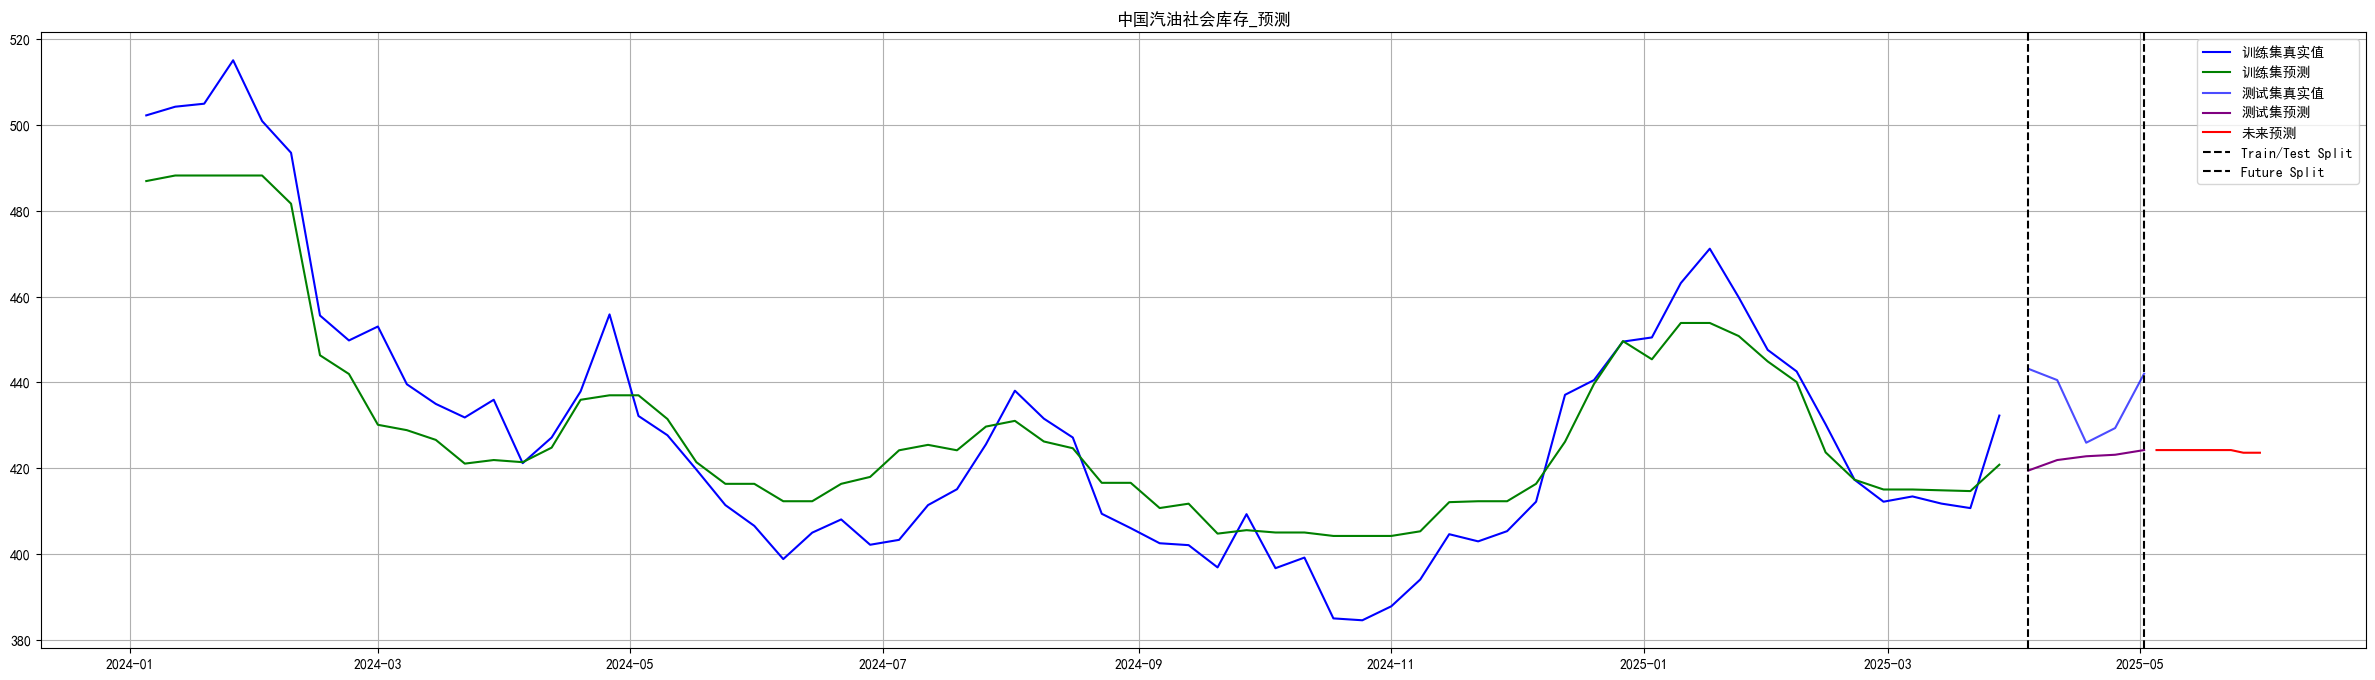

In [9]:
# 可视化
plt.figure(figsize=(30, 8))

plt.plot(train_data['Date'], y_train, label='训练集真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred, label='训练集预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集真实值', color='blue',alpha=0.7)
plt.plot(test_data['Date'], test_data['预测值'], label='测试集预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')

plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')
plt.title('中国汽油社会库存_预测')
plt.legend()
plt.grid(True)
plt.show()

---

In [10]:
future_predictions = future_data[['Date', '预测值']].copy()
future_predictions.columns = ['Date', '中国汽油社会库存']

future_predictions.to_excel('data_output_auto/中国汽油社会库存预测结果.xlsx', index=False)

---

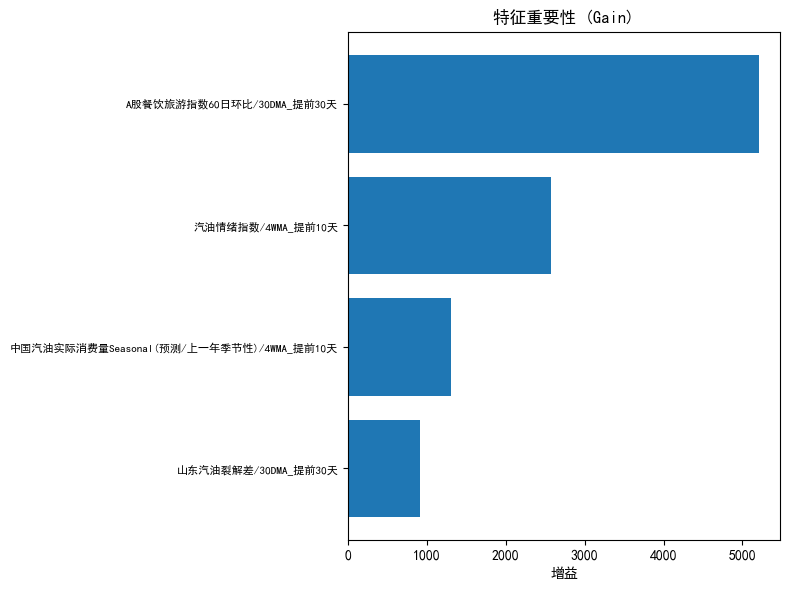

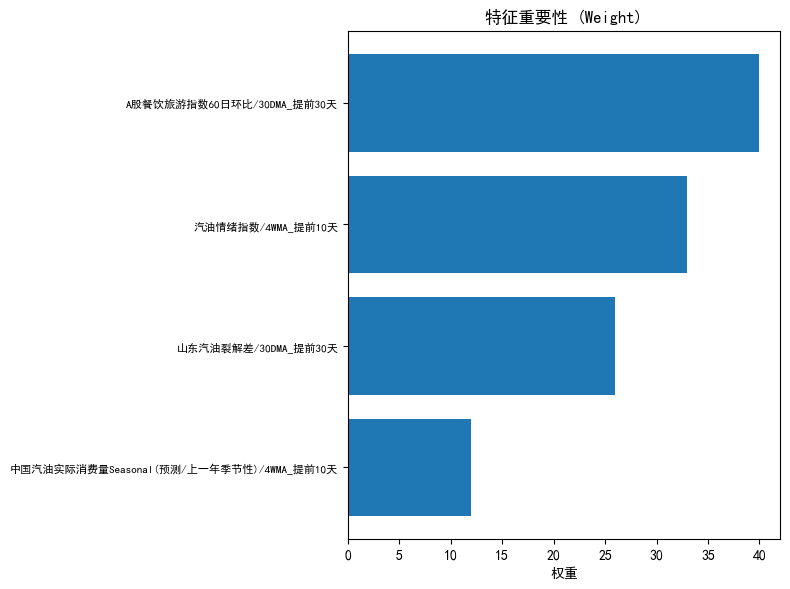

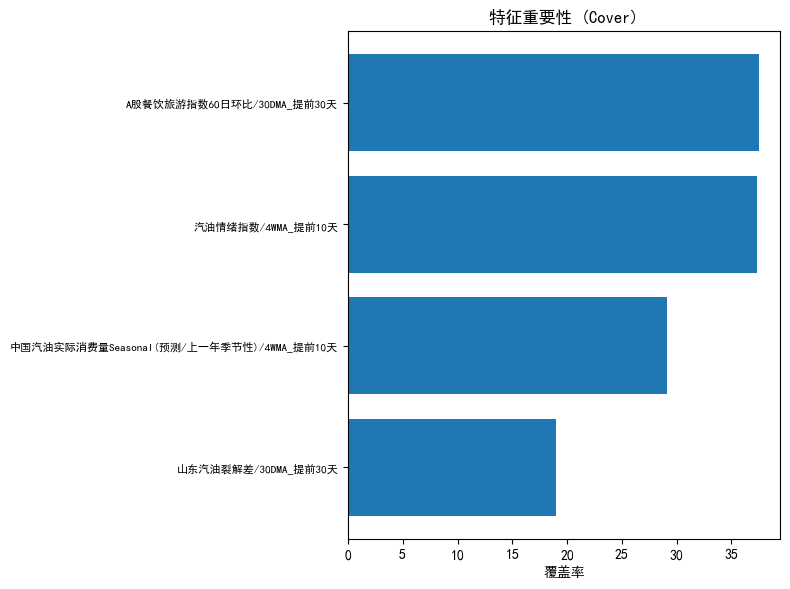

In [11]:
plot_feature_importance(xgb.get_booster(), X_train, importance_type='gain', title='特征重要性 (Gain)', xlabel='增益')
plot_feature_importance(xgb.get_booster(), X_train, importance_type='weight', title='特征重要性 (Weight)', xlabel='权重')
plot_feature_importance(xgb.get_booster(), X_train, importance_type='cover', title='特征重要性 (Cover)', xlabel='覆盖率')

- weight：告诉我们某个特征在决策树中出现的次数。它是一个 **频率指标**，但不一定说明这个特征对模型的预测能力有强大的影响。
- gain：更直接地反映了特征对模型性能的贡献，是一个 **效果指标**，表示该特征每次分裂时对模型的优化效果，gain 较高的特征能显著降低误差，通常是预测能力较强的特征。
- cover：反映了特征在决策树中所涉及的数据量，通常表示该特征在 **样本分布** 中的覆盖情况。高 cover 的特征可能影响到更多的样本，是模型中比较 **广泛影响** 的特征。


---

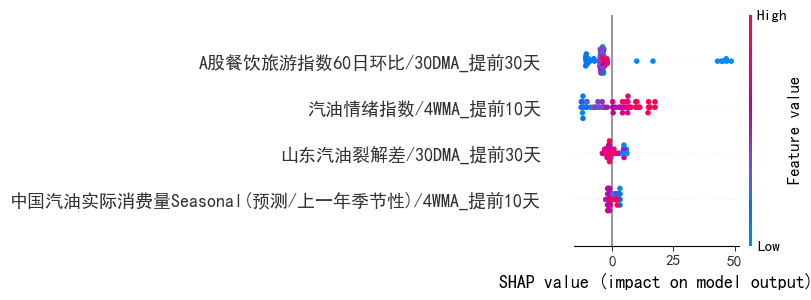

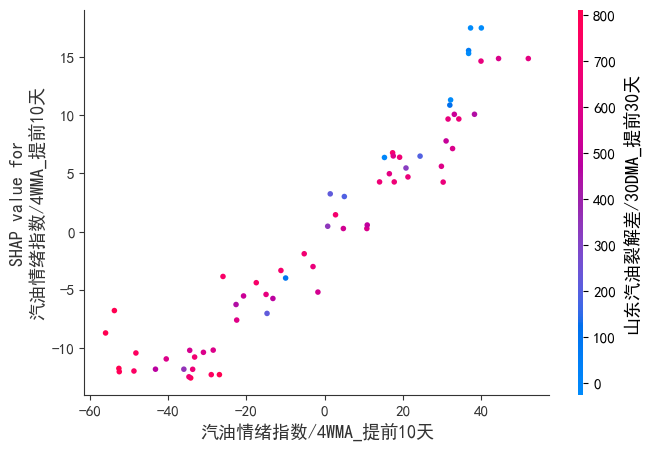

In [12]:
import shap
import matplotlib.pyplot as plt
import pandas as pd

# 确保 X_train_scaled 和 X_train 是 DataFrame
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# 创建 SHAP Explainer
explainer = shap.Explainer(xgb, X_train_scaled_df)

# 计算 SHAP 值
shap_values = explainer(X_train_scaled_df)

# 提取 SHAP 值数组
shap_values_array = shap_values.values

# 绘制 SHAP Summary Plot
shap.summary_plot(shap_values_array, X_train, feature_names=X_train.columns)

# 绘制单个特征的依赖图（转换 SHAP 值为数组）
shap.dependence_plot(
    '汽油情绪指数/4WMA_提前10天',
    shap_values_array,        # 提取的 SHAP 值数组
    X_train,                  # 原始数据
    feature_names=X_train.columns
)


---

In [13]:
from lime.lime_tabular import LimeTabularExplainer

---

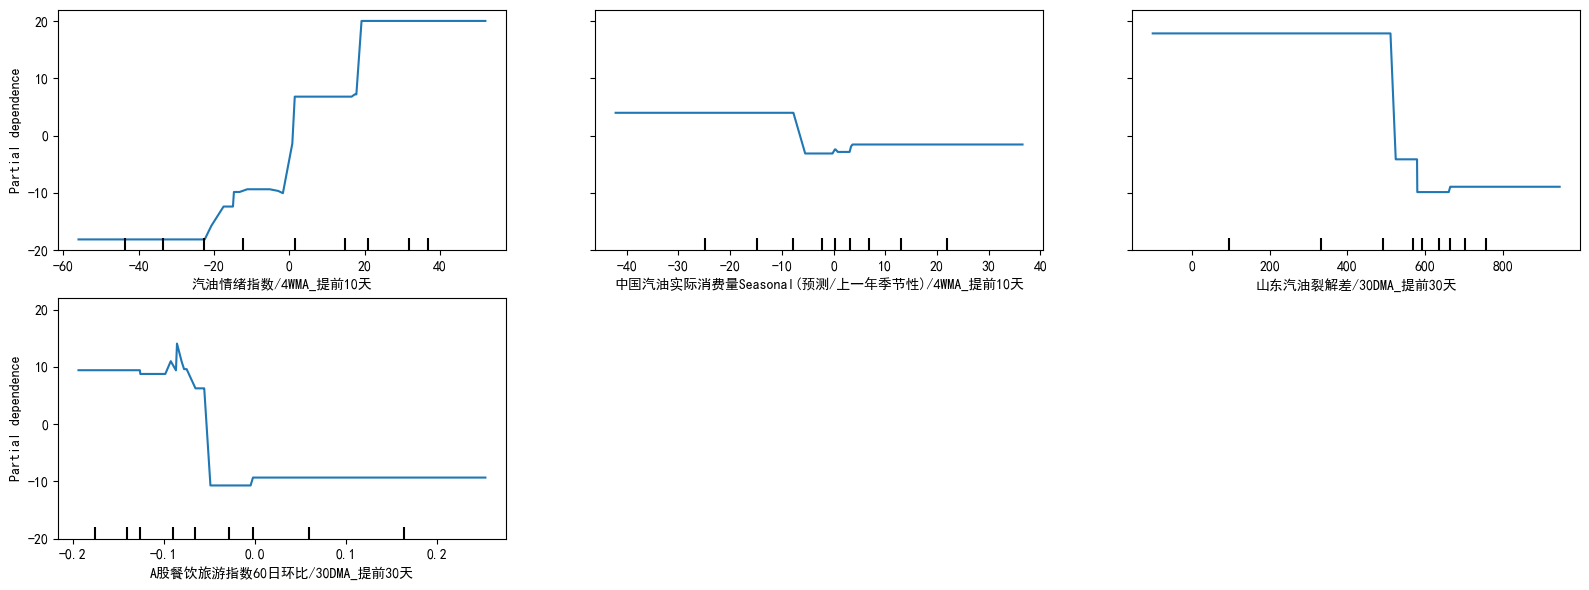

In [14]:
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import HistGradientBoostingRegressor
import matplotlib.pyplot as plt

# 训练替代模型
hgb = HistGradientBoostingRegressor()
hgb.fit(X_train, y_train)

# 设置特征列表
features_to_plot = X_train.columns.tolist()

# 调整图形大小（加宽）
fig, ax = plt.subplots(figsize=(16, 6))  # 设置宽度为 16，高度为 6

# 绘制部分依赖图
PartialDependenceDisplay.from_estimator(
    hgb, 
    X_train, 
    features=features_to_plot, 
    feature_names=X_train.columns,
    ax=ax  # 指定图形区域
)

plt.tight_layout()  # 自动调整子图布局，避免重叠
plt.show()



---

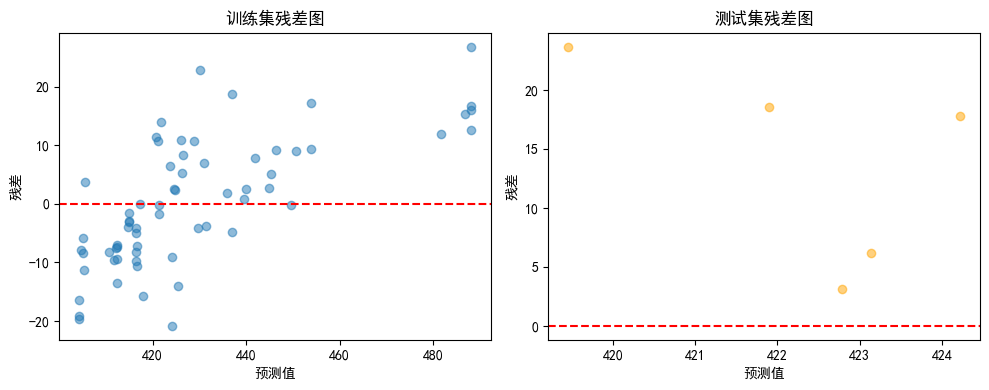

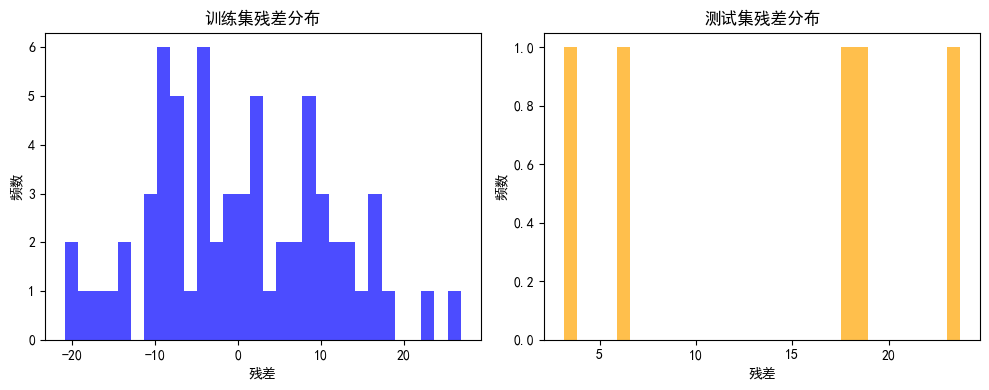

In [15]:
train_residual = y_train - y_train_pred
test_residual = y_test - y_test_pred

# 绘制残差图
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(y_train_pred, train_residual, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('预测值')
plt.ylabel('残差')
plt.title('训练集残差图')

plt.subplot(1, 2, 2)
plt.scatter(y_test_pred, test_residual, alpha=0.5, color='orange')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('预测值')
plt.ylabel('残差')
plt.title('测试集残差图')

plt.tight_layout()
plt.show()

# 绘制残差分布直方图
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(train_residual, bins=30, color='blue', alpha=0.7)
plt.title('训练集残差分布')
plt.xlabel('残差')
plt.ylabel('频数')

plt.subplot(1, 2, 2)
plt.hist(test_residual, bins=30, color='orange', alpha=0.7)
plt.title('测试集残差分布')
plt.xlabel('残差')
plt.ylabel('频数')

plt.tight_layout()
plt.show()

---

In [16]:
# 任务1: 合并训练集、测试集真实值和未来预测
# 获取2023年以后的训练集数据
train_data_2023 = train_data[train_data['Date'].dt.year >= 2023][['Date', '中国汽油社会库存']]
test_actual = test_data[['Date', '中国汽油社会库存']]

# 合并训练集和测试集的真实值
historical_actual = pd.concat([train_data_2023, test_actual])
historical_actual.columns = ['Date', '实际值']

# 获取未来预测值
future_pred = future_data[['Date', '预测值']]  # 修改这里的列名
future_pred.columns = ['Date', '预测值']

# 合并所有数据
merged_df = pd.merge(historical_actual, future_pred, on='Date', how='outer')
merged_df = merged_df.sort_values('Date', ascending=False)

# 将日期格式转换为年/月/日格式
merged_df['Date'] = merged_df['Date'].dt.strftime('%Y/%m/%d')

# 保存到Excel
merged_df.to_excel('eta/中国汽油社会库存_合并数据.xlsx', index=False,float_format='%.2f')
merged_df

,Date,实际值,预测值
89,2025/05/30,NaN,423.604401
88,2025/05/29,NaN,423.604401
87,2025/05/28,NaN,423.604401
86,2025/05/27,NaN,423.604401
85,2025/05/26,NaN,423.604401
...,...,...,...
4,2024/02/02,500.90,NaN
3,2024/01/26,515.06,NaN
2,2024/01/19,504.94,NaN
1,2024/01/12,504.24,NaN


In [17]:
# 任务2: 生成月度数据
# 获取2023年以后的实际值
actual_values = pd.concat([
    train_data[train_data['Date'].dt.year >= 2023][['Date', '中国汽油社会库存']],
    test_data[['Date', '中国汽油社会库存']]
])
actual_values.columns = ['Date', '实际值']

# 创建包含2024年及以后训练集预测值的DataFrame
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred[train_data['Date'].dt.year >= 2024]
})

# 重新构建predictions DataFrame
predictions = pd.concat([
    train_pred_2024,
    test_data[['Date', '预测值']],
    future_data[['Date', '预测值']]
], ignore_index=True)

# 重新合并实际值和预测值
monthly_df = pd.merge(actual_values, predictions, on='Date', how='outer')

# 转换为月度数据
monthly_df['Date'] = pd.to_datetime(monthly_df['Date'])
monthly_df.set_index('Date', inplace=True)
monthly_df = monthly_df.resample('ME').mean()
monthly_df.reset_index(inplace=True)
monthly_df = monthly_df.sort_values('Date', ascending=False)
# 将日期格式转换为年/月/日格式
monthly_df['Date'] = monthly_df['Date'].dt.strftime('%Y/%m/%d')

# 保存月度数据
monthly_df.to_excel('eta/中国汽油社会库存_月度数据.xlsx', index=False, float_format='%.2f')
monthly_df.head()


,Date,实际值,预测值
16,2025/05/31,442.0200,424.076111
15,2025/04/30,434.7475,421.817017
14,2025/03/31,417.0325,416.339966
13,2025/02/28,425.5675,424.029999
12,2025/01/31,458.4260,449.747864


---

In [18]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "中国汽油社会库存"

# 调用函数更新数据
success = update_excel_data(merged_df, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [19]:
from Lcel import update_excel_data
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "中国汽油社会库存"
# 调用函数更新数据
success = update_excel_data(monthly_df, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")


已完成：插入/更新数据，并重新计算“方向/偏差率” (protected_date = 2025/04/30)
数据已成功更新到Excel文件
